In [23]:
import Style_transfer as st
import torch
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn as nn
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
#!pip install tqdm
import tqdm
import os
import copy
import pandas as pd
import PIL 
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%config Completer.use_jedi = False

In [24]:
def save_results_image(content_im, style_im, result_im, reconstruction, malign_probability, 
                       l1_score, rejected, tag_pair, save_location, content_weight = 1, iterations = 1):
    f, axarr = plt.subplots(1, 4)
    f.set_size_inches(18.5, 5)
    axarr[0].imshow(content_im[0][0].detach().cpu().numpy(),cmap = 'gray')
    axarr[0].set_title("Content Image")
    axarr[1].imshow(style_im[0][0].detach().cpu().numpy(),cmap = 'gray')
    axarr[1].set_title("Style Image")
    axarr[2].imshow(result_im[0][0].detach().cpu().numpy(),cmap = 'gray')
    axarr[2].set_title("Resulting Image")
    axarr[3].imshow(reconstruction[0][0].detach().cpu().numpy(), cmap = 'gray')
    axarr[3].set_title("Reconstructed Image")
    plt.suptitle('Mal. prob:' + str(malign_probability) + '   L1 loss: ' + str(np.round(l1_score,3)) 
                 + '   Rejected: ' + str(rejected) + 
                 '\nContent photo:' + tag_pair[0] + '   Style photo: ' + tag_pair[1] + 
                 '\n Parameters = Iterations: ' + str(iterations) + '   Content weight: ' + str(content_weight),                                   
                 fontsize = 12)
    plt.savefig(save_location)
    plt.show()

In [25]:
from AnomalyDetector import Model, L1_measure
from Style_transfer import image_loader, plot_image, load_image

In [26]:
base_iterations = 250
base_cnt_weight = 1
iterations_up = [300, 350, 400, 450, 500]
iterations_down = [200, 150, 100]
content_weights = [1,5,10,100, 200, 500, 1000]

# fixed test options
# fixed_opt_w = [1, 5, 10, 5, 10, 250, 20]
# fixed_opt_iter = [500, 250, 250, 400, 400, 250, 750]
test_opt_iter = [5,10,25,50,100, 250, 500, 1000]

In [27]:
# define the style transfer prerequisited
st_class = st.StyleTransfer()
base_malign_path = '/home/ryznerf/Computer_Vision/pytorch_data_input/test/malignant/'
base_benign_path = '/home/ryznerf/Computer_Vision/pytorch_data_input/test/benign/'
save_folder = '/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/results_3/'

style = os.listdir(base_malign_path)
content = os.listdir(base_benign_path)

In [28]:
# define counts

random_pairs_count = 50
max_trials_per_pair = len(test_opt_iter)
softmax_cutoff = 0.85

# randomly select pairings
np.random.seed(300)
style_tags = np.random.choice(style, random_pairs_count)
content_tags = np.random.choice(content, random_pairs_count)
cont_style_pairs = list(zip(content_tags, style_tags))

In [29]:
#load and define the anomaly detector
model_name = 'default_AE_mix3'   # model name
model = Model(n_channels= 1, bilinear= True) 
checkpoint = torch.load('/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/saved_classifiers/AutoEncoders/' + model_name) # save location
model.load_state_dict(checkpoint['state_dict']) # load the state
model = model.to(device) # put it to gpu

# load the classifier
# classifier = torch.load('/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/saved_classifiers/model_full')
classifier = torch.load('/home/ryznerf/Computer_Vision/6.869_Computer_Vision_project/saved_classifiers/model_full_2')
classifier = classifier.to(device)

In [30]:
# determine the normalization parameters
def get_image_transforms():
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
#            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            transforms.Normalize([0.0858], [0.1819]),
        ])
    return transform

base_loc = '/home/ryznerf/Computer_Vision/pytorch_data_input'
len_total = len(os.listdir(base_loc + '/test/benign')) + len(os.listdir(base_loc + '/test/malignant'))
#len(dataset)
dataset = datasets.ImageFolder('/home/ryznerf/Computer_Vision/pytorch_data_input/test', transform = get_image_transforms())
loader = torch.utils.data.DataLoader(dataset, batch_size= len(dataset), num_workers=4)

In [31]:
data, labels = next(iter(loader))
cnt = 0
prob_mal = []
prob_mal_correct = []
prob_benign = []
prob_benign_correct = []

for i in range(len(data)):
    softmax = nn.Softmax(dim=1)
    res = np.round((softmax(classifier(torch.unsqueeze(data[i], dim=0).to(device))).detach().cpu().numpy()),3)
    if labels[i] == 1:
        malign_probability = res[0][1]
        prob_mal.append(malign_probability)
        if malign_probability > 0.5:
            prob_mal_correct.append(malign_probability)
    else: 
        benign_probability = res[0][0]
        prob_benign.append(benign_probability)
        if benign_probability <= 0.5:
            prob_benign_correct.append(benign_probability)

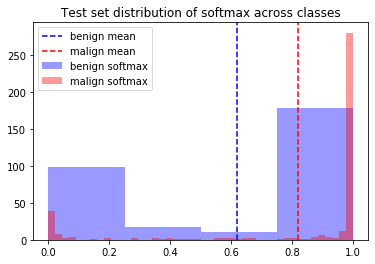

In [32]:
#sns.distplot(prob_correct, stat="probability")
sns.distplot(prob_benign, color="b", kde = False, label = 'benign softmax')
plt.axvline(np.mean(prob_benign), color='blue', linestyle='dashed', linewidth=1.5, label = 'benign mean')
plt.axvline(np.mean(prob_mal), color='red', linestyle='dashed', linewidth=1.5, label = 'malign mean')
sns.distplot(prob_mal, color="r", kde = False, label = 'malign softmax')
plt.legend()
plt.title('Test set distribution of softmax across classes')
plt.savefig('class_dist_all.png')
plt.show()

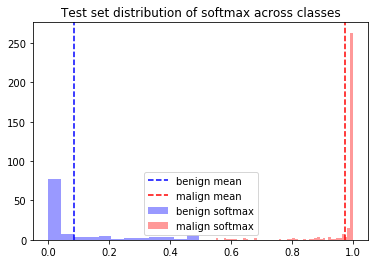

In [33]:
sns.distplot(prob_benign_correct, color="b", kde = False, label = 'benign softmax')
plt.axvline(np.mean(prob_benign_correct), color='blue', linestyle='dashed', linewidth=1.5, label = 'benign mean')
plt.axvline(np.mean(prob_mal_correct), color='red', linestyle='dashed', linewidth=1.5, label = 'malign mean')
sns.distplot(prob_mal_correct, color="r", kde = False, label = 'malign softmax')
plt.legend()
plt.title('Test set distribution of softmax across classes')
plt.savefig('class_dist_selected.png')
plt.show()

In [22]:
np.max(prob_mal_correct)

1.0

In [24]:
np.mean(prob_mal)

0.8297067

In [95]:
np.mean(prob_correct)

0.75635463

In [67]:
# determine the normalization parameters
def get_image_transforms():
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize([0.0858], [0.1819]),
        ])
    return transform

base_loc = '/home/ryznerf/Computer_Vision/pytorch_data_input'
len_total = len(os.listdir(base_loc + '/train/benign')) + len(os.listdir(base_loc + '/train/malignant'))
#
dataset = datasets.ImageFolder('/home/ryznerf/Computer_Vision/pytorch_data_input/train', transform = get_image_transforms())
loader = torch.utils.data.DataLoader(dataset, batch_size= len(dataset), num_workers=4)

In [68]:
# determine the normalization parameters
def get_image_transforms():
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize([0.0858], [0.1819]),
        ])
    return transform

base_loc = '/home/ryznerf/Computer_Vision/pytorch_data_input'
len_total = len(os.listdir(base_loc + '/test/benign')) + len(os.listdir(base_loc + '/test/malignant'))
#
dataset_test = datasets.ImageFolder('/home/ryznerf/Computer_Vision/pytorch_data_input/test', transform = get_image_transforms())
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size= len(dataset), num_workers=4)

In [69]:
data, labels = next(iter(loader))
dec_b_train = []
dec_b_test = []

for i in range(len(data)):      
    reconstruction = model(torch.unsqueeze(data[i], dim=0).to(device))
    l1_score = L1_measure(reconstruction, torch.unsqueeze(data[i], dim=0).to(device))
    l1_score = l1_score.detach().cpu().numpy()[0]
    dec_b_train.append(l1_score)
    
data, labels = next(iter(loader_test))
for i in range(len(data)):      
    reconstruction = model(torch.unsqueeze(data[i], dim=0).to(device))
    l1_score = L1_measure(reconstruction, torch.unsqueeze(data[i], dim=0).to(device))
    l1_score = l1_score.detach().cpu().numpy()[0]
    dec_b_test.append(l1_score)

In [71]:
np.mean(dec_b_test)

0.23686261

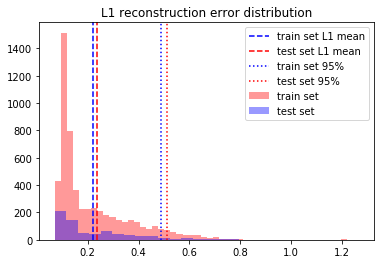

In [112]:
sns.distplot(dec_b_train, color="r", kde = False, label = 'train set')
sns.distplot(dec_b_test, color="b", kde = False, label = 'test set')
plt.axvline(np.mean(dec_b_train), color='blue', linestyle='dashed', linewidth=1.5, label = 'train set L1 mean')
plt.axvline(np.mean(dec_b_test), color='red', linestyle='dashed', linewidth=1.5, label = 'test set L1 mean')
plt.axvline(np.percentile(dec_b_train, 92.5), color='blue', linestyle='dotted', linewidth=1.5, label = 'train set 95%')
plt.axvline(np.percentile(dec_b_test, 92.5), color='red', linestyle='dotted', linewidth=1.5, label = 'test set 95%')
plt.title('L1 reconstruction error distribution')
plt.legend()
plt.savefig('anomaly')
plt.show()

In [104]:
np.percentile(dec_b_train, 90)
np.percentile(dec_b_test, 90)

0.4682121098041535